In [87]:
import os

import snap
import numpy as np
import matplotlib.pyplot as plt

In [20]:
from collections import defaultdict, deque

In [3]:
NUM_NODES = 1000
OUT_DEGREE = 4
Rnd = snap.TRnd(42)

In [41]:
def getSingleDeltaValue(G, s):
    # Traverse the bfs graph from start node.
    tree = snap.GetBfsTree(G, s, True, False)
    queue = deque([s])

    # dictionary from v: bool specifiying if the node has already
    # been popped from the queue before
    visited = {}
    # maps from node id to distance from s
    distance = {s: 0}

    # dictionary from v: P_s(v) which is a list of node ids that
    # precede v in the bfs starting at s.
    parents = {}
    # same as above but list of node ids that follow v  in the bfs starting at s
    descendents = {}

    # maps v: \sigma_{sv} -- the # of shortest paths from s to v.
    sigmas = {s: 1}

    # All leaf nodeIDs in the bfs tree (ie, have now out edges)
    leafs = []
    while len(queue) != 0:
        nodeID = queue.popleft()
        if nodeID in visited:
            continue
        node = tree.GetNI(nodeID)

        # Add outgoing edge to queue.
        neighbors = [node.GetOutNId(i) for i in xrange(node.GetOutDeg())]
        for neighbor in neighbors:
            queue.append(neighbor)
            if neighbor not in distance:
                distance[neighbor] = 1 + distance[nodeID]
            else:
                assert distance[neighbor] == 1 + distance[nodeID]

        # We're a leaf if no out edges
        if len(neighbors) == 0:
            leafs.append(nodeID)

        # Store parents and descendents for efficiency.
        descendents[nodeID] = neighbors
        parents[nodeID] = [node.GetInNId(i)
                                 for i in xrange(node.GetInDeg())]
        if nodeID != s:
            assert nodeID not in sigmas
            sigmas[nodeID] = 0
            for parent in parents[node.GetId()]:
                sigmas[node.GetId()] += sigmas[parent]

        # Mark node as explored.
        visited[nodeID] = True

    # Traverse in order of furthest node (which is always a leave)
    assert len(leafs) > 0
    visited = {}
    # maps {(v,w): delta_s({v,w})} as defined in Algorithm 1.
    deltas = {}
    leafDict = {leaf: True for leaf in leafs}
    sortedDistance = sorted(distance.items(), key=lambda x: -x[1])
    for w, _ in sortedDistance:
        node = tree.GetNI(w)
        for v in parents[w]:
            # A leave, so calculate base case for incoming edges from above bfs.
            if w in leafDict:
                deltas[(v, w)] = float(sigmas[v]) / float(sigmas[w])
                deltas[(w, v)] = deltas[(v, w)]
            # non-leave w.
            else:
                total = 1
                for x in descendents[w]:
                    total += deltas[(w,x)]
                deltas[(v,w)] = float(sigmas[v]) / float(sigmas[w]) * total
                deltas[(w,v)] = deltas[(v,w)]
    return deltas

In [42]:
def getDeltaValues(G):
    '''
    Calculates the \delta values for all nodes in G as defined in Algorithm 1.
    
    returns: dictionary of dictionaries mappings {s: {(v, w): \delta_s({v,w})}}
    '''
    delta = {}
    for snode in G.Nodes():
        s = snode.GetId()
        delta[s] = getSingleDeltaValue(G, s)        
    return delta  

In [46]:
def ExactEdgeCentrality(G, includeDuplicates=False):
    '''
    Calculates the exact node centrality of G accoring to Algorithm 1. Returns
    a hash table of all edges in G and their respective centralities.
    
    param: snap.PUNGraph, the graph
    returns: {(v,w}: float}, exact betweenness centrality of G for all edges in G.
    '''
    delta = getDeltaValues(G)
    centrality = {}
    for edge in G.Edges():
        v,w = edge.GetId()
        centrality[(v,w)] = 0
        for node in G.Nodes():
            s = node.GetId()
            assert s in delta
            centrality[(v,w)] += (delta[s][(v,w)] if (v,w) in delta[s] else 0)
        if includeDuplicates:
            centrality[(w,v)] = centrality[(v,w)]
    return centrality

In [47]:
def testExactEdgeCentrality():
    testG = snap.GenPrefAttach(NUM_NODES, OUT_DEGREE, Rnd)
    centrality = ExactEdgeCentrality(testG)
    unusedNodes = snap.TIntFltH()
    expectedCentrality = snap.TIntPrFltH()
    snap.GetBetweennessCentr(testG, unusedNodes, expectedCentrality, 1.0)

    for key in expectedCentrality:
        (v,w) = key.GetVal1(), key.GetVal2()
        expected = expectedCentrality[key]
        if abs(centrality[(v,w)] - expected) >= 1e-8:
            print centrality[(v,w)], expected
        assert abs(centrality[(v,w)] - expected) < 1e-8

In [75]:
%%timeit
testExactEdgeCentrality()

1 loop, best of 3: 22.3 s per loop


In [76]:
def ApproxEdgeCentrality(G, maxSamples, maxEdgeDelta, includeDuplicates=False):
    '''
    Calculates the approximate edge centrality for all edges in the graph G.
    
    Samples at most maxSample nodes and updates edges only as long as edgeDelta <= maxEdgeDelta.
    
    See homework for details.
    
    Returns the same type as ExactEdgeCentrality.
    '''
    for _ in xrange(maxSamples):
        v = G.GetRndNId(Rnd)
        edgeDelta = defaultdict(int)
        edgeSampleCount = defaultdict(int)
        for edge, deltav in getSingleDeltaValue(G, v).iteritems():
            if edgeDelta[edge] <= maxEdgeDelta:
                edgeDelta[edge] += deltav
                edgeSampleCount[edge] += 1
    centrality = {}
    for edge in G.Edges():
        v,w = edge.GetId()
        if (v,w) in edgeSampleCount:
            centrality[(v,w)] = G.GetNodes() / float(edgeSampleCount[(v,w)]) * edgeDelta[(v,w)]
        else:
            centrality[(v,w)] = 0
        if includeDuplicates:
            centrality[(w,v)] = centrality[(v,w)]
    return centrality

In [77]:
def testApproxEdgeCentrality():
    testG = snap.GenPrefAttach(NUM_NODES, OUT_DEGREE, Rnd)
    centrality = ApproxEdgeCentrality(testG, testG.GetNodes() / 10, 5 * testG.GetNodes())
    unusedNodes = snap.TIntFltH()
    expectedCentrality = snap.TIntPrFltH()
    snap.GetBetweennessCentr(testG, unusedNodes, expectedCentrality, 1.0)

    errorSum = 0.0
    for key in expectedCentrality:
        (v,w) = key.GetVal1(), key.GetVal2()
        expected = expectedCentrality[key]
        errorSum += (centrality[(v,w)] - expected)**2
        
    print errorSum
    print np.sqrt(errorSum / len(expectedCentrality))

In [78]:
%%timeit
testApproxEdgeCentrality()

1.9474889235e+11
6986.36144233
2.7792187214e+11
8345.93341372
4.60884310018e+11
10747.5509831
1.84403400604e+11
6798.26383195
1 loop, best of 3: 2.36 s per loop


In [92]:
def Q2():
    prefAttachmentGraph = snap.GenPrefAttach(NUM_NODES, OUT_DEGREE, Rnd)
    N = prefAttachmentGraph.GetNodes()
    global exactEdgeCentrality, approxEdgeCentrality
    exactEdgeCentrality = ExactEdgeCentrality(prefAttachmentGraph)
    approxEdgeCentrality = ApproxEdgeCentrality(testG, N / 10, 5 * N)
    assert len(exactEdgeCentrality) == len(exactEdgeCentrality)
    
    Y1 = sorted(exactEdgeCentrality.values(), reverse=True)
    Y2 = sorted(approxEdgeCentrality.values(), reverse=True)
    X = range(len(Y1))
    
    plt.close()
    plt.title("Exact and Approximate Betweeness Centrality Ordering")
    plt.xlabel("x-th largest edge")
    plt.ylabel("Calculated betweeness centrality")
    plt.semilogy(X, Y1)
    plt.semilogy(X, Y2)
    plt.legend(["Exact Algorithm", "Approximate Algorithm"])
    if not os.path.exists("output"):
        os.mkdir("output")
    plt.savefig("output/2", dpi=500)
    plt.show()

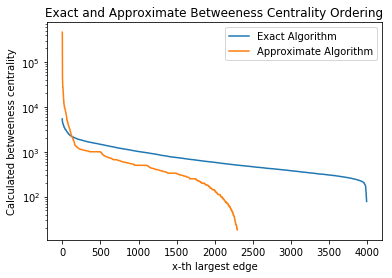

In [93]:
Q2()

In [94]:
testG = snap.GenPrefAttach(NUM_NODES, OUT_DEGREE, Rnd)

In [95]:
%%timeit
centrality = ApproxEdgeCentrality(testG, testG.GetNodes() / 10, 5 * testG.GetNodes())

1 loop, best of 3: 1.8 s per loop


In [96]:
%%timeit
ExactEdgeCentrality(testG)

1 loop, best of 3: 21.8 s per loop
